# Import relevant library 

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import itertools
from matplotlib import cm
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import tensorflow as tf
from tensorflow import keras
from xgboost import XGBClassifier

# Data load

In [3]:
data = np.loadtxt('data.txt', delimiter=',')
labels = np.loadtxt('labels.txt', delimiter=',', dtype=int)

In [4]:
data.shape, labels.shape

((2000, 10), (2000,))

- Data length commonsulate with labels

# Helper functions

In [5]:
# Helper function to generate binary classification report
def test_report(clf, X_test, y_test):
    pred = clf.predict(X_test)
    accuracy = (accuracy_score(y_test, pred)) * 100
    clf_report = pd.DataFrame(classification_report(y_test, pred, output_dict=True))
    print("Test Result:\n================================================")
    print(f"Accuracy Score: {accuracy:.2f}")
    print("_______________________________________________")
    print(f"CLASSIFICATION REPORT:\n{clf_report}")
    print("_______________________________________________")
    print(f"Confusion Matrix: \n {confusion_matrix(y_test, pred)}\n")
    return accuracy

In [6]:
# Plot loss curve
def plot_loss_curve(history):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epoch_range = range(len(history.history['loss']))

  plt.figure(figsize=(10, 6))
  # Plot loss
  plt.plot(epoch_range, loss, label='training_loss')
  plt.plot(epoch_range, val_loss, label='validation_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()
  plt.grid(True)

  # Plot accuracy
  plt.plot(epoch_range, accuracy, label='training_accuracy')
  plt.plot(epoch_range, val_accuracy, label='validation_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend()
  plt.grid(True)

In [7]:
def display_confusion_matrix():
    figsize = (5, 5)

    # Create the confusion matrix
    cm = confusion_matrix(y_test, tf.round(y_preds))
    cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
    n_classes = cm.shape[0]

    # Let's prettify it
    fig, ax = plt.subplots(figsize=figsize)
    # Create a matrix plot
    cax = ax.matshow(cm, cmap=plt.cm.Blues)
    fig.colorbar(cax)

    # Create classes
    classes = False

    if classes:
      labels = classes
    else:
      labels = np.arange(cm.shape[0])

    # Label the axes
    ax.set(title="Confusion Matrix",
           xlabel="Predicted label",
           ylabel="True label",
           xticks=np.arange(n_classes),
           yticks=np.arange(n_classes),
           xticklabels=labels,
           yticklabels=labels)

    # Set x-axis labels to bottom
    ax.xaxis.set_label_position("bottom")
    ax.xaxis.tick_bottom()

    # Adjust label size
    ax.xaxis.label.set_size(20)
    ax.yaxis.label.set_size(20)
    ax.title.set_size(20)

    # Set threshold for different colors
    threshold = (cm.max() + cm.min()) / 2.

    # Plot the text on each cell
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
               horizontalalignment="center",
               color="white" if cm[i, j] > threshold else "black",
               size=15)

# Data explorations

In [8]:
# Create dataframe to explore the data
df = pd.DataFrame(data)

In [9]:
df.head(5)

,0,1,2,3,4,5,6,7,8,9
0,0.169017,0.338823,0.418715,0.880381,1.142260,0.387203,0.763070,0.905567,1.075242,0.716769
1,0.135751,0.944009,0.882218,1.013292,1.026292,0.354763,1.139477,0.413869,0.462191,0.208194
2,0.242827,0.152332,0.359337,0.820920,0.682525,0.741629,0.059621,0.865597,0.898697,0.646062
3,0.905068,0.162121,0.702304,0.933761,0.861965,0.953543,0.129436,0.087241,0.170528,0.536696
4,0.558882,1.184310,0.644041,0.840139,0.868405,0.900544,1.194059,0.437783,0.770556,1.225055


In [10]:
# Add target value as a column to the dataframe
df['target'] = labels

In [11]:
df['target'].unique()

array([1, 0])

- Target is binary (Binary classifiction)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       2000 non-null   float64
 1   1       2000 non-null   float64
 2   2       2000 non-null   float64
 3   3       2000 non-null   float64
 4   4       2000 non-null   float64
 5   5       2000 non-null   float64
 6   6       2000 non-null   float64
 7   7       2000 non-null   float64
 8   8       2000 non-null   float64
 9   9       2000 non-null   float64
 10  target  2000 non-null   int64  
dtypes: float64(10), int64(1)
memory usage: 172.0 KB


- No missing values
- No catagorical data

In [13]:
df.describe()

,0,1,2,3,4,5,6,7,8,9,target
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,0.621427,0.623940,0.623654,0.623221,0.625543,0.623611,0.618125,0.627540,0.627944,0.622767,0.500000
std,0.326549,0.332072,0.331324,0.326997,0.333612,0.325565,0.328745,0.331540,0.329043,0.325306,0.500125
min,0.000017,0.000866,0.000069,0.003198,0.001607,0.001357,0.001857,0.000469,0.000110,0.000237,0.000000
25%,0.360080,0.362218,0.366721,0.368454,0.352231,0.370484,0.360600,0.368510,0.380553,0.370311,0.000000
50%,0.613880,0.626358,0.625887,0.624090,0.623764,0.626714,0.619028,0.639152,0.634019,0.621954,0.500000
75%,0.865965,0.874354,0.882263,0.872714,0.885518,0.863385,0.860764,0.873734,0.873127,0.870478,1.000000
max,1.491916,1.488008,1.485904,1.465687,1.452949,1.493512,1.478565,1.480303,1.478127,1.466941,1.000000


- 25th percentile, median and 75th percentile are equally distributed.
- Mean for all attrubutes are almost same
- Standard deviations are similar for all attributes.

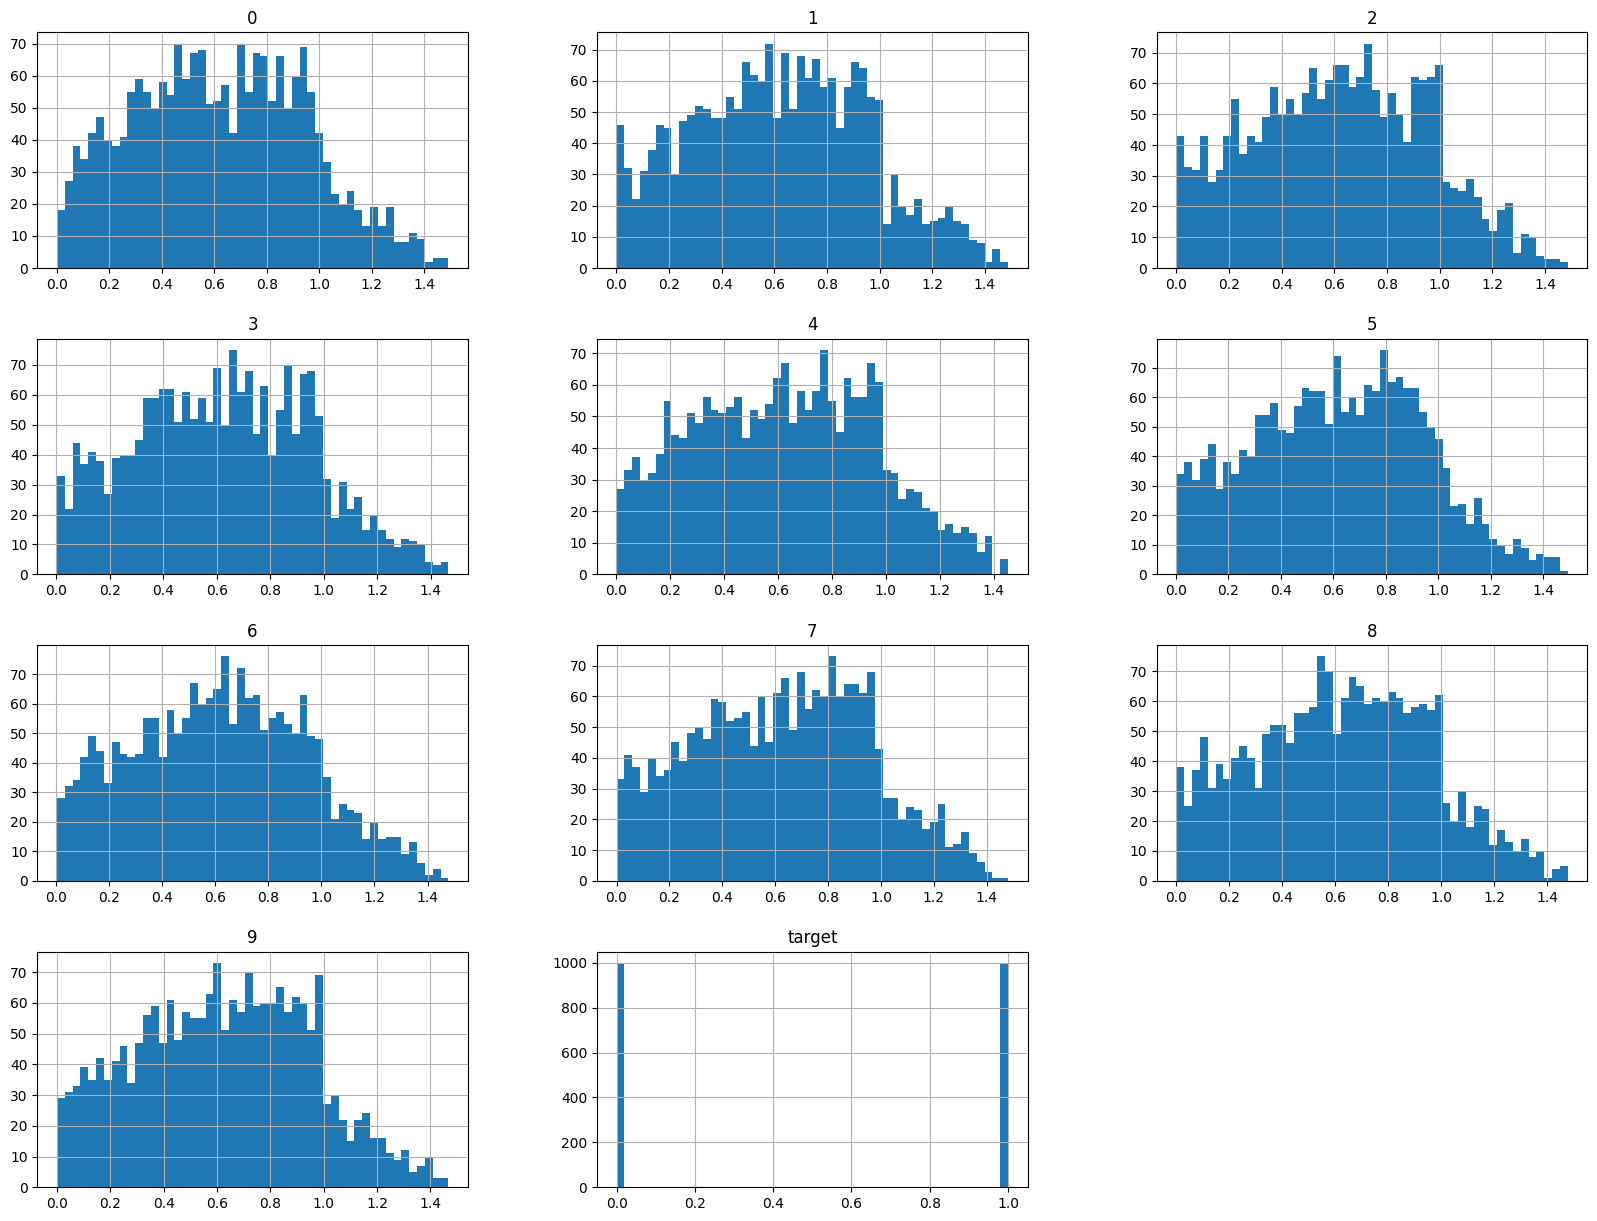

In [14]:
# Visualize the distributions of attributes
df.hist(bins=50, figsize=(20, 15))
plt.show()

- Data are symmetrically ditributed with no skew.

<Axes: xlabel='target'>

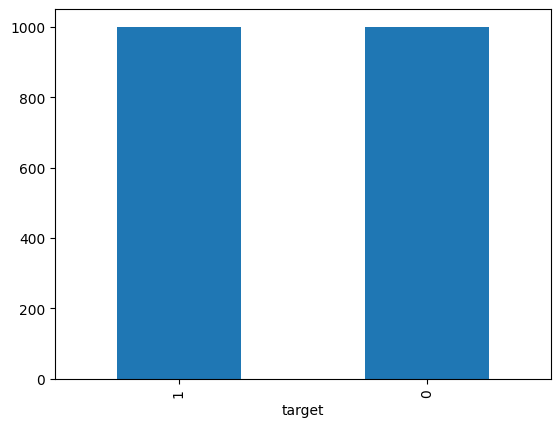

In [15]:
df['target'].value_counts().plot(kind='bar')

- Targets are evenly distributes

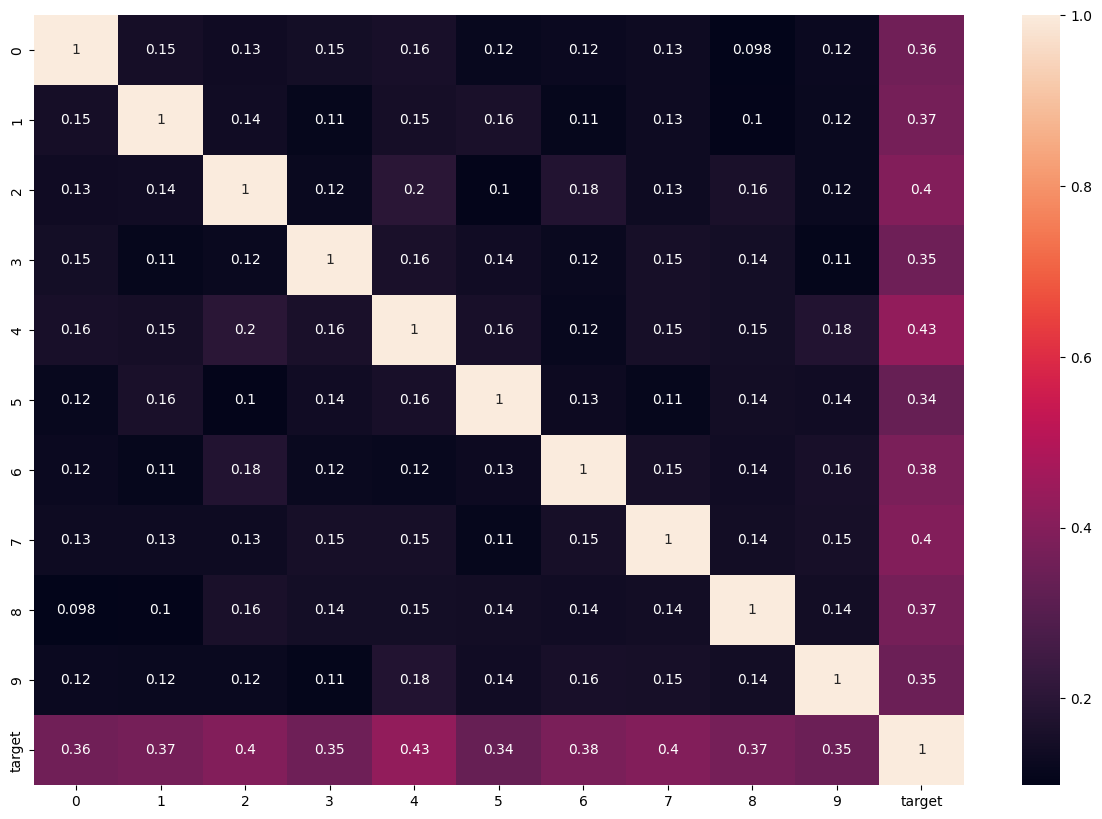

In [16]:
# Correaltion between different attributes 
fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(df.corr(), annot = True, ax=ax)
plt.show()

- No significant corelation among the attributes

## Summary of data exploration

- The problem is a binary classification problem with balanced target values.
- No missing data points
- No data cleaning and transformation (normalization/scalling) is required.
- None of the attributes has significant correlation with the target values.


# Data Preparation for Training

- Data cleaning not required
- No missing data
- Data is balances for classification
- No scaling is required

## Train/test split

In [17]:
# Test ratio 20%
X_train, X_test, y_train, y_test= train_test_split(data, labels, test_size=.20, random_state=42)

In [18]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape 

((1600, 10), (1600,), (400, 10), (400,))

## Summary

- No scaling required

# Experiment Design

We will run total 8 binary classification models and make a comparison of the outcome results.
* Model 1: Logistic Regression.
* Model 2: K-Nearest Neighbor Classifier(KNN).
* Model 3: Gaussian Naive Bias.
* Model 4: Support Vector Machines.
* Model 5: Random Forest Classifier.
* Model 6: Gradient Boosting Machines - XGBoost.
* Model 7: Neural Net.

Metrics: For binary classification, we will primarily focus on the accuracy. In addition we will also look at F1 score. Confusion matrix will be analyzed to observe models predictions.

## Logistic Regression

### Model Design

In [19]:
# Logistics regression with sklearn default vlaues.
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

LogisticRegression()

In [20]:
log_reg_accuracy = test_report(log_reg, X_test, y_test)

Test Result:
Accuracy Score: 91.50
_______________________________________________
CLASSIFICATION REPORT:
                    0           1  accuracy   macro avg  weighted avg
precision    0.912037    0.918478     0.915    0.915258      0.915064
recall       0.929245    0.898936     0.915    0.914091      0.915000
f1-score     0.920561    0.908602     0.915    0.914581      0.914940
support    212.000000  188.000000     0.915  400.000000    400.000000
_______________________________________________
Confusion Matrix: 
 [[197  15]
 [ 19 169]]



#### Building model with K-fold validation and GridSearch to find the best parameters

In [21]:
cv = StratifiedShuffleSplit(n_splits=10, test_size=.20, random_state=42)

In [22]:
params = {
    'penalty': ['l1','l2'],
    'C': [0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,2,3,4,5,6,7,8,9,10]
}
log_reg = LogisticRegression(solver='liblinear')
grid = GridSearchCV(log_reg, param_grid=params, scoring='accuracy', n_jobs =-1, cv=cv, verbose=1)

In [23]:
grid.fit(X_train, y_train)

Fitting 10 folds for each of 36 candidates, totalling 360 fits


GridSearchCV(cv=StratifiedShuffleSplit(n_splits=10, random_state=42, test_size=0.2,
            train_size=None),
             estimator=LogisticRegression(solver='liblinear'), n_jobs=-1,
             param_grid={'C': [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 2, 3,
                               4, 5, 6, 7, 8, 9, 10],
                         'penalty': ['l1', 'l2']},
             scoring='accuracy', verbose=1)

### Results

In [24]:
log_reg_grid_val_score = round(grid.best_score_ * 100, 2)
print(f'Best Score: {log_reg_grid_val_score}')
print('Best Params:', grid.best_params_)
print('Best Estimator:', grid.best_estimator_)

Best Score: 90.16
Best Params: {'C': 0.6, 'penalty': 'l2'}
Best Estimator: LogisticRegression(C=0.6, solver='liblinear')


In [25]:
logreg_grid_score = test_report(grid, X_test, y_test)

Test Result:
Accuracy Score: 91.75
_______________________________________________
CLASSIFICATION REPORT:
                    0           1  accuracy   macro avg  weighted avg
precision    0.920188    0.914439    0.9175    0.917313      0.917486
recall       0.924528    0.909574    0.9175    0.917051      0.917500
f1-score     0.922353    0.912000    0.9175    0.917176      0.917487
support    212.000000  188.000000    0.9175  400.000000    400.000000
_______________________________________________
Confusion Matrix: 
 [[196  16]
 [ 17 171]]



* Best result achieved with C=0.6 and solver='liblinear'

### K-Nearest Neighbor Classifier(KNN)

#### Model Design

In [26]:
knn_classifier = KNeighborsClassifier()

In [27]:
knn_classifier.fit(X_train, y_train)

KNeighborsClassifier()

In [28]:
accuracy = test_report(knn_classifier, X_test, y_test)

Test Result:
Accuracy Score: 90.75
_______________________________________________
CLASSIFICATION REPORT:
                    0           1  accuracy   macro avg  weighted avg
precision    0.888889    0.931429    0.9075    0.910159      0.908883
recall       0.943396    0.867021    0.9075    0.905209      0.907500
f1-score     0.915332    0.898072    0.9075    0.906702      0.907220
support    212.000000  188.000000    0.9075  400.000000    400.000000
_______________________________________________
Confusion Matrix: 
 [[200  12]
 [ 25 163]]



#### Building KNN model with K-fold validation and GridSearch to find the best parameters

In [29]:
params = {
    'n_neighbors': [3,5,11,19],
    'weights': ['uniform','distance']
}
knn = KNeighborsClassifier()
grid = GridSearchCV(knn, param_grid=params, scoring='accuracy', n_jobs =-1, cv=cv, verbose=1)
grid.fit(X_train, y_train)

Fitting 10 folds for each of 8 candidates, totalling 80 fits


GridSearchCV(cv=StratifiedShuffleSplit(n_splits=10, random_state=42, test_size=0.2,
            train_size=None),
             estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': [3, 5, 11, 19],
                         'weights': ['uniform', 'distance']},
             scoring='accuracy', verbose=1)

### Results

In [30]:
knn_grid_val_score = round(grid.best_score_ * 100, 2)
print(f'Best Score: {log_reg_grid_val_score}')
print('Best Params:', grid.best_params_)
print('Best Estimator:', grid.best_estimator_)

Best Score: 90.16
Best Params: {'n_neighbors': 19, 'weights': 'uniform'}
Best Estimator: KNeighborsClassifier(n_neighbors=19)


In [31]:
knn_grid_score = test_report(grid, X_test, y_test)

Test Result:
Accuracy Score: 91.00
_______________________________________________
CLASSIFICATION REPORT:
                    0           1  accuracy   macro avg  weighted avg
precision    0.872881    0.963415      0.91    0.918148      0.915432
recall       0.971698    0.840426      0.91    0.906062      0.910000
f1-score     0.919643    0.897727      0.91    0.908685      0.909343
support    212.000000  188.000000      0.91  400.000000    400.000000
_______________________________________________
Confusion Matrix: 
 [[206   6]
 [ 30 158]]



* Best result achieved with n_neighbors=19, weights='uniform'

### Gaussian Naive Bias

### Model Design

In [32]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)

GaussianNB()

In [33]:
accuracy = test_report(gnb, X_test, y_test)

Test Result:
Accuracy Score: 92.50
_______________________________________________
CLASSIFICATION REPORT:
                    0           1  accuracy   macro avg  weighted avg
precision    0.917431    0.934066     0.925    0.925749      0.925250
recall       0.943396    0.904255     0.925    0.923826      0.925000
f1-score     0.930233    0.918919     0.925    0.924576      0.924915
support    212.000000  188.000000     0.925  400.000000    400.000000
_______________________________________________
Confusion Matrix: 
 [[200  12]
 [ 18 170]]



#### Gaussian Naive Bias with Grid Search

In [34]:
params = {}
gnb = GaussianNB()
grid = GridSearchCV(gnb, param_grid=params, scoring='accuracy', n_jobs =-1, cv=cv, verbose=1)
grid.fit(X_train, y_train)

Fitting 10 folds for each of 1 candidates, totalling 10 fits


GridSearchCV(cv=StratifiedShuffleSplit(n_splits=10, random_state=42, test_size=0.2,
            train_size=None),
             estimator=GaussianNB(), n_jobs=-1, param_grid={},
             scoring='accuracy', verbose=1)

### Results

In [35]:
gnb_grid_val_score = round(grid.best_score_ * 100, 2)
print(f'Best Score: {log_reg_grid_val_score}')
print('Best Params:', grid.best_params_)
print('Best Estimator:', grid.best_estimator_)

Best Score: 90.16
Best Params: {}
Best Estimator: GaussianNB()


In [36]:
gnb_grid_score = test_report(grid, X_test, y_test)

Test Result:
Accuracy Score: 92.50
_______________________________________________
CLASSIFICATION REPORT:
                    0           1  accuracy   macro avg  weighted avg
precision    0.917431    0.934066     0.925    0.925749      0.925250
recall       0.943396    0.904255     0.925    0.923826      0.925000
f1-score     0.930233    0.918919     0.925    0.924576      0.924915
support    212.000000  188.000000     0.925  400.000000    400.000000
_______________________________________________
Confusion Matrix: 
 [[200  12]
 [ 18 170]]



### Support Vector Machines

#### Model Design

In [37]:
svm_classifier = SVC(kernel='linear', C=1.0)
svm_classifier.fit(X_train, y_train)

SVC(kernel='linear')

In [38]:
accuracy = test_report(svm_classifier, X_test, y_test)

Test Result:
Accuracy Score: 91.75
_______________________________________________
CLASSIFICATION REPORT:
                    0           1  accuracy   macro avg  weighted avg
precision    0.912442    0.923497    0.9175    0.917970      0.917638
recall       0.933962    0.898936    0.9175    0.916449      0.917500
f1-score     0.923077    0.911051    0.9175    0.917064      0.917425
support    212.000000  188.000000    0.9175  400.000000    400.000000
_______________________________________________
Confusion Matrix: 
 [[198  14]
 [ 19 169]]



#### Support vector machine with grid search

In [39]:
params = {
    'C': [0.001, 0.01, 0.1, 1, 10], 
    'gamma' : [0.001,0.001, 0.01, 0.1, 1]
}
svc = SVC(kernel='rbf', probability=True)
grid = GridSearchCV(svc, param_grid=params, scoring='accuracy', n_jobs =-1, cv=cv, verbose=1)
grid.fit(X_train, y_train)

Fitting 10 folds for each of 25 candidates, totalling 250 fits


GridSearchCV(cv=StratifiedShuffleSplit(n_splits=10, random_state=42, test_size=0.2,
            train_size=None),
             estimator=SVC(probability=True), n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10],
                         'gamma': [0.001, 0.001, 0.01, 0.1, 1]},
             scoring='accuracy', verbose=1)

### Results

In [40]:
svm_grid_val_score = round(grid.best_score_ * 100, 2)
print(f'Best Score: {log_reg_grid_val_score}')
print('Best Params:', grid.best_params_)
print('Best Estimator:', grid.best_estimator_)

Best Score: 90.16
Best Params: {'C': 10, 'gamma': 1}
Best Estimator: SVC(C=10, gamma=1, probability=True)


In [41]:
svm_grid_score = test_report(grid, X_test, y_test)

Test Result:
Accuracy Score: 90.75
_______________________________________________
CLASSIFICATION REPORT:
                    0           1  accuracy   macro avg  weighted avg
precision    0.903226    0.912568    0.9075    0.907897      0.907617
recall       0.924528    0.888298    0.9075    0.906413      0.907500
f1-score     0.913753    0.900270    0.9075    0.907011      0.907416
support    212.000000  188.000000    0.9075  400.000000    400.000000
_______________________________________________
Confusion Matrix: 
 [[196  16]
 [ 21 167]]



### Random Forest Classifier

#### Model Design

In [42]:
rf_classifier = RandomForestClassifier(n_estimators=100, max_depth=None, random_state=42)
rf_classifier.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [43]:
accuracy = test_report(rf_classifier, X_test, y_test)

Test Result:
Accuracy Score: 98.00
_______________________________________________
CLASSIFICATION REPORT:
                    0           1  accuracy   macro avg  weighted avg
precision    0.967890    0.994505      0.98    0.981198      0.980399
recall       0.995283    0.962766      0.98    0.979024      0.980000
f1-score     0.981395    0.978378      0.98    0.979887      0.979977
support    212.000000  188.000000      0.98  400.000000    400.000000
_______________________________________________
Confusion Matrix: 
 [[211   1]
 [  7 181]]



#### Random forest classifier with grid search

In [44]:
params = {
    'max_features': [1, 3, 10],
    'min_samples_split': [2, 3, 10],
    'min_samples_leaf': [1, 3, 10],
    'bootstrap': [False],
    'n_estimators' :[20,60],
    'criterion': ["entropy", "gini"]
}
rfc = RandomForestClassifier()
grid = GridSearchCV(rfc, param_grid=params, scoring='accuracy', n_jobs =-1, cv=cv, verbose=1)
grid.fit(X_train, y_train)

Fitting 10 folds for each of 108 candidates, totalling 1080 fits


GridSearchCV(cv=StratifiedShuffleSplit(n_splits=10, random_state=42, test_size=0.2,
            train_size=None),
             estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'bootstrap': [False], 'criterion': ['entropy', 'gini'],
                         'max_features': [1, 3, 10],
                         'min_samples_leaf': [1, 3, 10],
                         'min_samples_split': [2, 3, 10],
                         'n_estimators': [20, 60]},
             scoring='accuracy', verbose=1)

### Results

In [45]:
rfc_grid_val_score = round(grid.best_score_ * 100, 2)
print(f'Best Score: {log_reg_grid_val_score}')
print('Best Params:', grid.best_params_)
print('Best Estimator:', grid.best_estimator_)

Best Score: 90.16
Best Params: {'bootstrap': False, 'criterion': 'entropy', 'max_features': 1, 'min_samples_leaf': 3, 'min_samples_split': 3, 'n_estimators': 60}
Best Estimator: RandomForestClassifier(bootstrap=False, criterion='entropy', max_features=1,
                       min_samples_leaf=3, min_samples_split=3,
                       n_estimators=60)


In [46]:
rfc_grid_score = test_report(grid, X_test, y_test)

Test Result:
Accuracy Score: 98.25
_______________________________________________
CLASSIFICATION REPORT:
                    0           1  accuracy   macro avg  weighted avg
precision    0.968037    1.000000    0.9825    0.984018      0.983059
recall       1.000000    0.962766    0.9825    0.981383      0.982500
f1-score     0.983759    0.981030    0.9825    0.982394      0.982476
support    212.000000  188.000000    0.9825  400.000000    400.000000
_______________________________________________
Confusion Matrix: 
 [[212   0]
 [  7 181]]



## Gradient Boosting Machines - XGBoost

### Model Design

In [47]:
# Defining all the parameters
params = {
    'max_depth': range (2, 10, 1),
    'n_estimators': range(60, 220, 40),
    'learning_rate': [0.1, 0.01, 0.05]
}

In [48]:
# Building model
xgb = XGBClassifier(objective='binary:logistic')
# Parameter estimating using GridSearch
grid = GridSearchCV(xgb, param_grid=params, scoring='accuracy', n_jobs =-1, cv=cv, verbose=1)
# Fitting the model
grid.fit(X_train, y_train)

Fitting 10 folds for each of 96 candidates, totalling 960 fits


GridSearchCV(cv=StratifiedShuffleSplit(n_splits=10, random_state=42, test_size=0.2,
            train_size=None),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_p...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.01, 0.05],
                         'max_depth': range(2, 10),
                         'n_estimators': range(60, 220, 40)},
             scoring='accuracy', verbose=1)

In [49]:
xgb_grid_val_score = round(grid.best_score_ * 100, 2)
print('Best Score:', xgb_grid_val_score) 
print('Best Params:', grid.best_params_)
print('Best Estimator:', grid.best_estimator_)

Best Score: 96.75
Best Params: {'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 60}
Best Estimator: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=60, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)


In [50]:
xgb_grid_score = test_report(grid, X_test, y_test)

Test Result:
Accuracy Score: 98.25
_______________________________________________
CLASSIFICATION REPORT:
                    0           1  accuracy   macro avg  weighted avg
precision    0.968037    1.000000    0.9825    0.984018      0.983059
recall       1.000000    0.962766    0.9825    0.981383      0.982500
f1-score     0.983759    0.981030    0.9825    0.982394      0.982476
support    212.000000  188.000000    0.9825  400.000000    400.000000
_______________________________________________
Confusion Matrix: 
 [[212   0]
 [  7 181]]



## Neural network

### Model Design

In [51]:
model = keras.Sequential([
    keras.layers.Dense(128, activation='relu', input_shape=(10,)),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])


In [52]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


In [53]:
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test))

Epoch 1/50
50/50 [==============================] - 1s 6ms/step - loss: 0.6446 - accuracy: 0.5806 - val_loss: 0.6026 - val_accuracy: 0.7375
Epoch 2/50
50/50 [==============================] - 0s 2ms/step - loss: 0.5447 - accuracy: 0.7775 - val_loss: 0.4770 - val_accuracy: 0.7950
Epoch 3/50
50/50 [==============================] - 0s 2ms/step - loss: 0.4039 - accuracy: 0.8562 - val_loss: 0.3243 - val_accuracy: 0.8975
Epoch 4/50
50/50 [==============================] - 0s 2ms/step - loss: 0.3225 - accuracy: 0.8669 - val_loss: 0.2819 - val_accuracy: 0.9000
Epoch 5/50
50/50 [==============================] - 0s 2ms/step - loss: 0.2956 - accuracy: 0.8769 - val_loss: 0.2521 - val_accuracy: 0.9000
Epoch 6/50
50/50 [==============================] - 0s 2ms/step - loss: 0.2862 - accuracy: 0.8775 - val_loss: 0.2431 - val_accuracy: 0.8975
Epoch 7/50
50/50 [==============================] - 0s 2ms/step - loss: 0.2873 - accuracy: 0.8719 - val_loss: 0.2446 - val_accuracy: 0.9100
Epoch 8/50
50/50 [==

In [54]:
y_preds = model.predict(X_test)

13/13 [==============================] - 0s 1ms/step


In [55]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
nn_test_score = round(test_accuracy * 100, 2)
print(f'Test loss: {test_loss}, Test accuracy: {test_accuracy}')


13/13 [==============================] - 0s 2ms/step - loss: 0.2131 - accuracy: 0.9025
Test loss: 0.21308763325214386, Test accuracy: 0.9024999737739563


In [56]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [57]:
unique_values, counts = np.unique(y_test, return_counts=True)
unique_values, counts

(array([0, 1]), array([212, 188]))

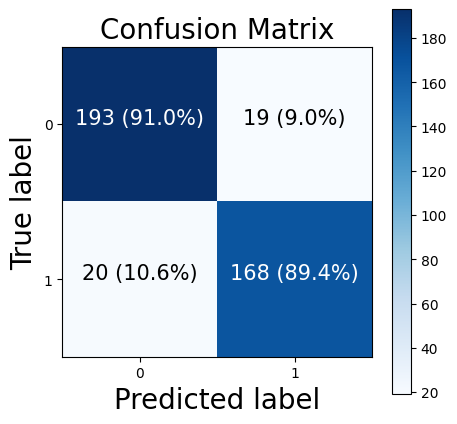

In [58]:
display_confusion_matrix()

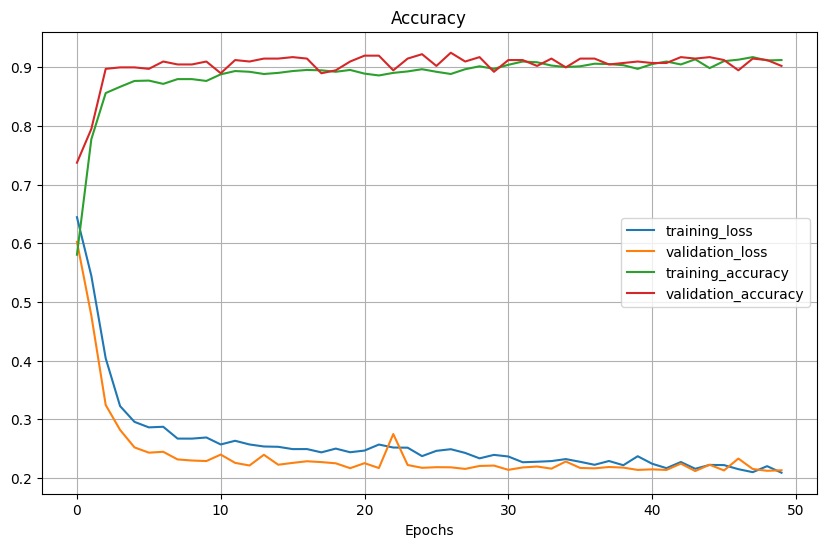

In [59]:
plot_loss_curve(history)

- Validation accuracy and loss is higher and lower than training accuracy and loss, this is because regularization is applied for training data while no regularization is applied for validation data. Since, we have a very small and simple dataset, any further complex model might be a overkill the the problem.

## Results Comparison

In [60]:
score_df = pd.DataFrame(
    [
        ['Logistic Regression', logreg_grid_score, log_reg_grid_val_score],
        ['K-Nearest Neighbors', knn_grid_score, knn_grid_val_score],
        ['Gaussian Naïve Bayes', gnb_grid_score, gnb_grid_val_score],
        ['Support Vector Machines', svm_grid_score, svm_grid_val_score],
        ['Random Forest Tree Classifier', rfc_grid_score, rfc_grid_val_score],
        ['Artificial Neural Networks', nn_test_score, None],
        ['GBM - XGBoost', xgb_grid_score, xgb_grid_val_score], 
    ],
    columns= ['Model', 'Test Score', 'Validation Score']
)

In [61]:
score_df

,Model,Test Score,Validation Score
0,Logistic Regression,91.75,90.16
1,K-Nearest Neighbors,91.00,89.47
2,Gaussian Naïve Bayes,92.50,89.91
3,Support Vector Machines,90.75,90.69
4,Random Forest Tree Classifier,98.25,96.84
5,Artificial Neural Networks,90.25,NaN
6,GBM - XGBoost,98.25,96.75


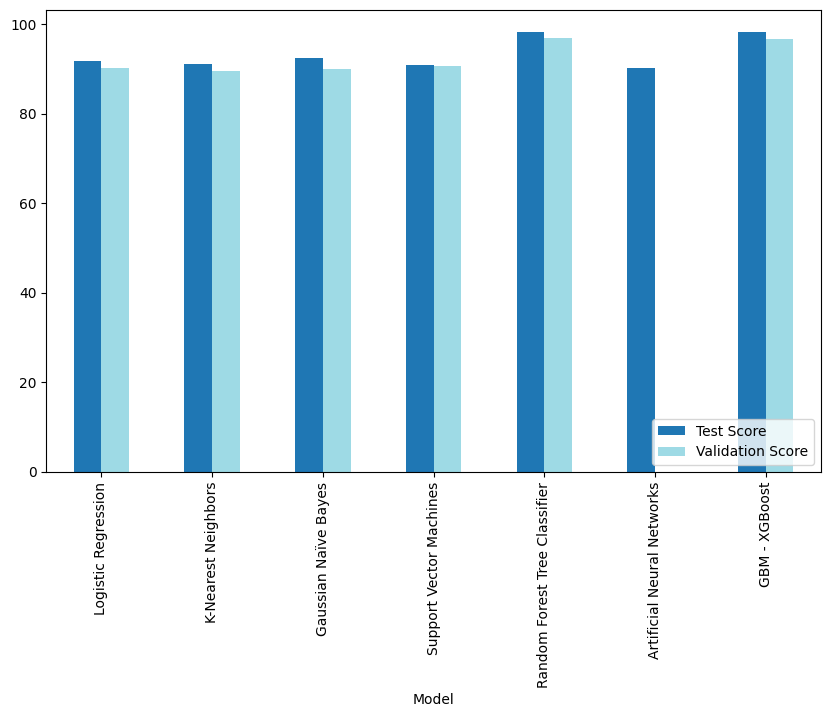

In [62]:

score_df.plot(x="Model", y=["Test Score", "Validation Score"], kind="bar", colormap='tab20', figsize=(10,6))
plt.legend(loc="lower right")
plt.show()

## Experiment Summary

- From the exploratory data analysis, the dataset seems to be very simple, normally distributed and features has no significant correlation with the target value.
- Dataset is balanced and we have 1000 positive and 1000 negative labels. As such, accuracy is considered as the most important evaluation matric for this binary classification problem. 
- Dataset is fairly small (2000 data points). So, training and test data are also small. Generalization by any classifier are unlikely to be good.
- To make balance between bias and variance, we have used total 7 models, starting with a very simple Logistics regression classifier and ending with Nural network. For such a simple dataset, simplier models are likely to yield better generalization than a complex model like Nural network.
- To fight overfitting and underfitting, we have used regularization and crossvalidation with different combination of hyperparameters.
- Finally, looking at the comparative result graph, all the models resulted above 90% of accuracy. Random forest tree and XGBoost models are most performant with an accuracy of more that 98% that use bagging and boosting respectively.

- Random forest classifier or XGBoost classifier could be used to label unseen data with the given hyper parameter. 